<a href="https://colab.research.google.com/github/hendradarwin/covid-19-prediction/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %tensorflow_version 2.x # make sure that collab use tensorflow 2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import datetime

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/virgiawan/covid-19-prediction/master/dataset/global_total.csv \
    -O /tmp/global_total.csv

time_trimmed shape =  (65,)
series_trimmed shape =  (65,)


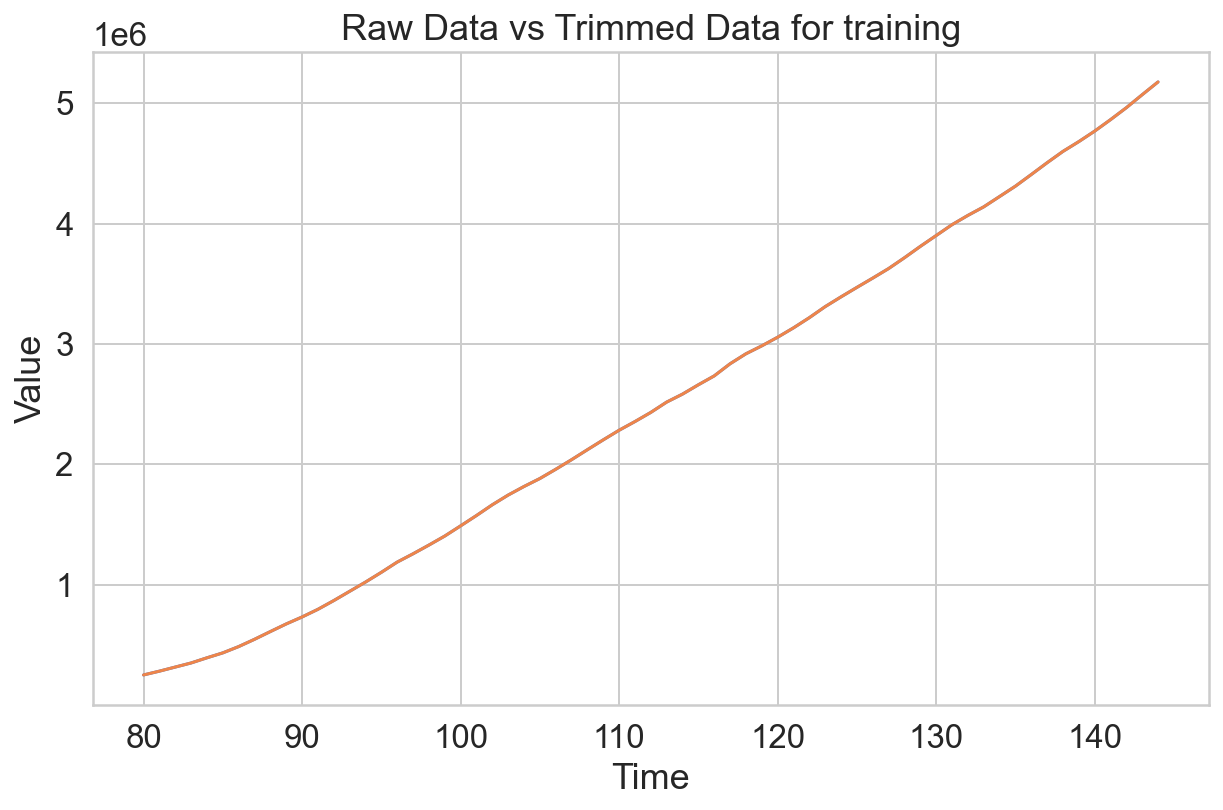

In [3]:
import csv
time_step = []
temps = []


# with open('/tmp/global_total.csv') as csvfile:
with open('D:\\total_cases.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)

series_trimmed = series[80:]
time_trimmed = time[80:]



series = series_trimmed
time = time_trimmed

split_time = 50



plt.figure(figsize=(10, 6))
plt.title("Raw Data vs Trimmed Data for training")
plot_series(time, series)
plot_series(time_trimmed, series_trimmed)

print("time_trimmed shape = ", time_trimmed.shape)
print("series_trimmed shape = ", series_trimmed.shape)


In [10]:
time_train = time_trimmed[:split_time]
x_train = series_trimmed[:split_time]
time_valid = time_trimmed[split_time:]
x_valid = series_trimmed[split_time:]

# hyper parameter
window_size = 3
batch_size = 2
shuffle_buffer_size = 10




In [11]:
# ini buat yg pake DNN
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
# ini buat yg pake RNN
def windowed_dataset_rnn(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [12]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(2).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [13]:
tf.keras.backend.clear_session()

# DNN
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([  
  tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

# RNN
# train_set = windowed_dataset_rnn(x_train, window_size, batch_size, shuffle_buffer_size)
# model = tf.keras.models.Sequential([  
#   tf.keras.layers.Conv1D(filters=7, kernel_size=5,
#                       strides=1, padding="causal",
#                       activation="relu",
#                       input_shape=[None, 1]),  
#   tf.keras.layers.LSTM(64, return_sequences=True),
#   tf.keras.layers.LSTM(64, return_sequences=True),                      
#   tf.keras.layers.Dense(80, input_shape=[window_size], activation="relu"),
#   tf.keras.layers.Dense(10, activation="relu"),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 6000000)
# ])

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-9 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-9, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=500) # , callbacks=[lr_schedule]


h 309/500
24/24 [==============================] - 0s 1ms/step - loss: 41044.6445 - mae: 41865.3477
Epoch 310/500
24/24 [==============================] - 0s 1ms/step - loss: 36025.5352 - mae: 36079.8672
Epoch 311/500
24/24 [==============================] - 0s 1ms/step - loss: 52398.1250 - mae: 51508.7344
Epoch 312/500
24/24 [==============================] - 0s 1ms/step - loss: 56381.3711 - mae: 55992.1797
Epoch 313/500
24/24 [==============================] - 0s 1ms/step - loss: 77355.3984 - mae: 78171.6953
Epoch 314/500
24/24 [==============================] - 0s 1ms/step - loss: 155767.7344 - mae: 155360.7969
Epoch 315/500
24/24 [==============================] - 0s 1ms/step - loss: 74708.6953 - mae: 75431.9609
Epoch 316/500
24/24 [==============================] - 0s 1ms/step - loss: 109083.5625 - mae: 110882.8594
Epoch 317/500
24/24 [==============================] - 0s 1ms/step - loss: 120776.6016 - mae: 118517.2266
Epoch 318/500
24/24 [==============================] - 0s 1ms/

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-8, 1e-4, 0, 60])

<Figure size 1152x720 with 0 Axes>

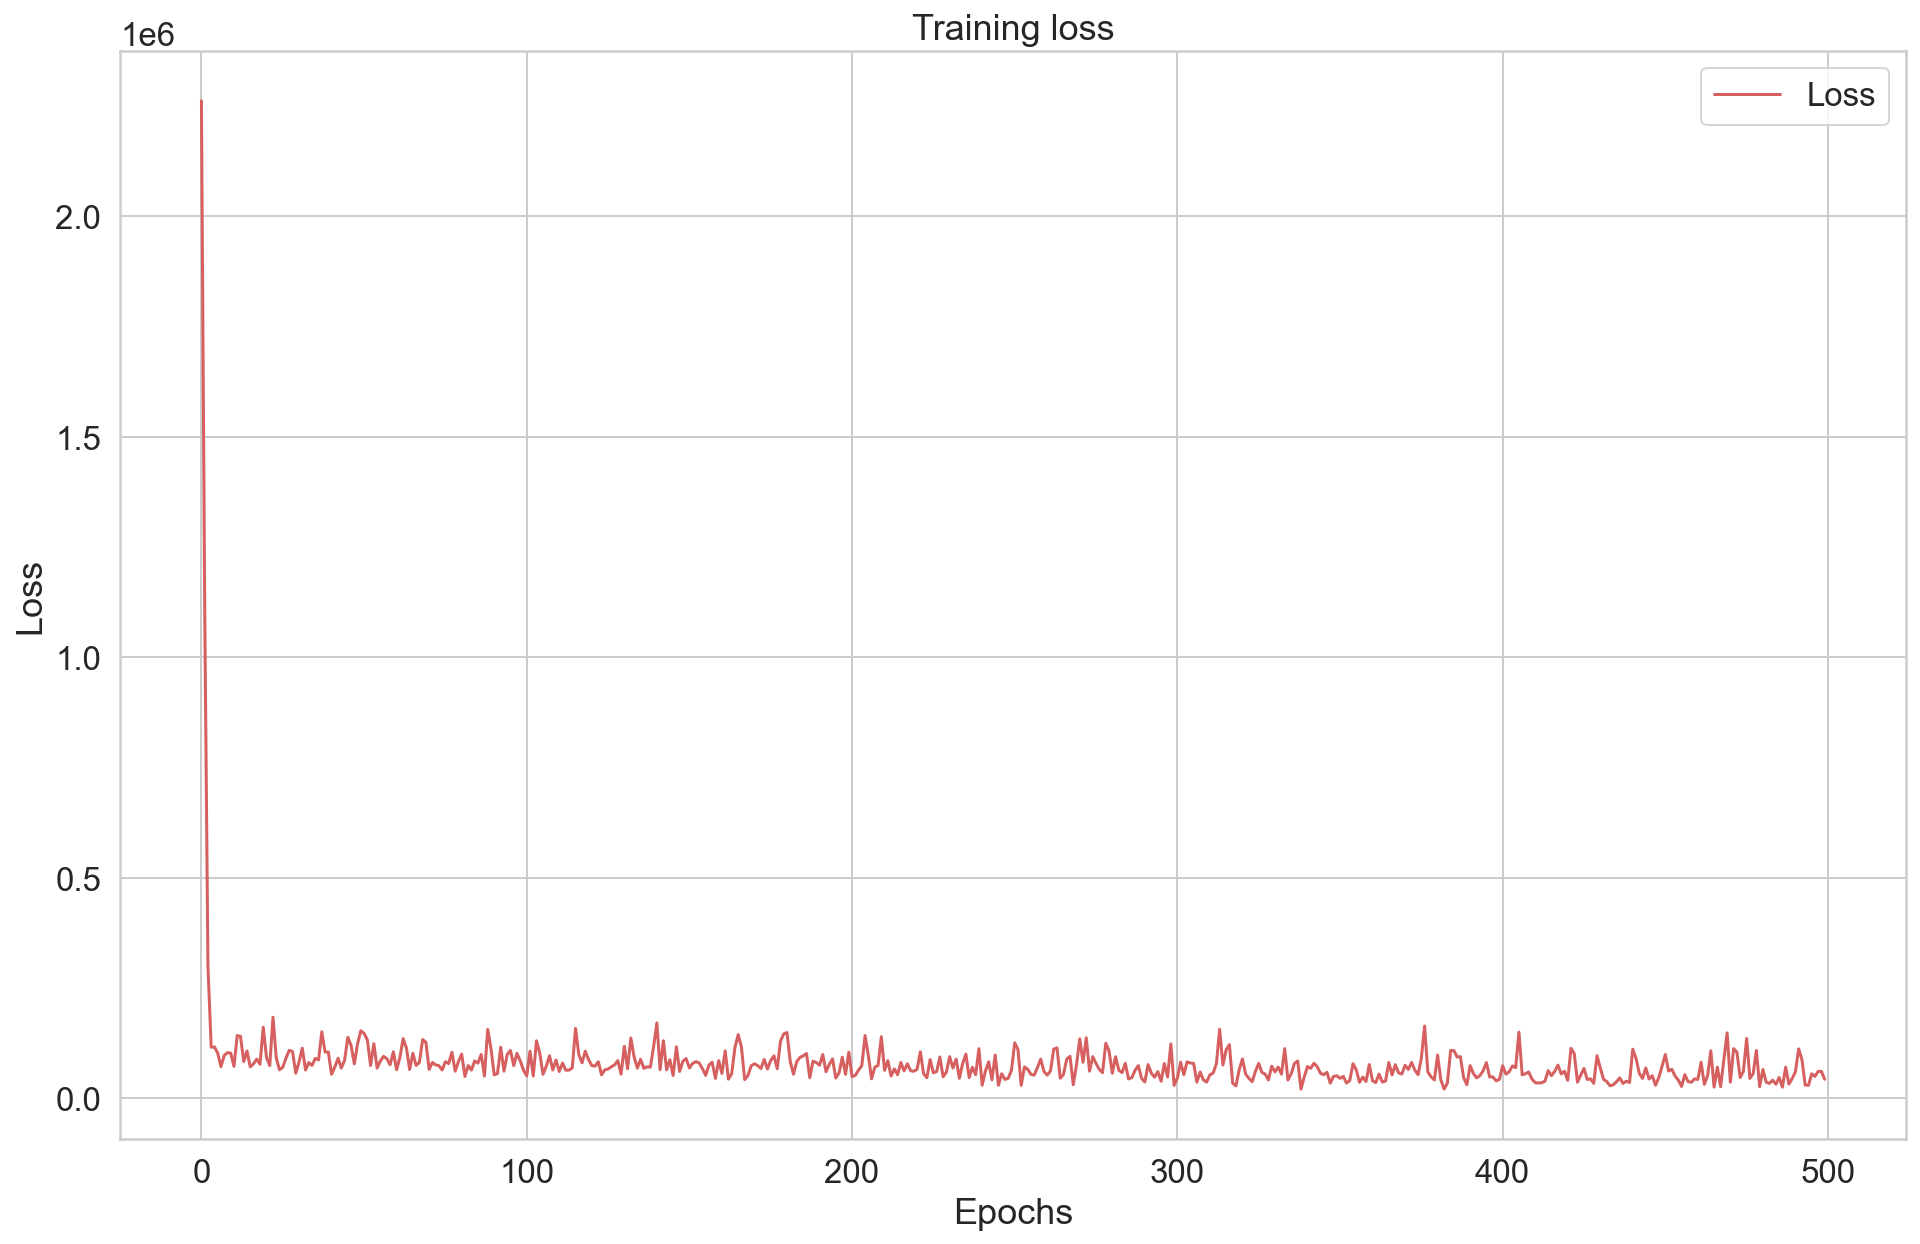

<Figure size 1152x720 with 0 Axes>

In [14]:
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
# ini forecast untuk RNN
rnn_forecast = model_forecast(model, series_trimmed[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

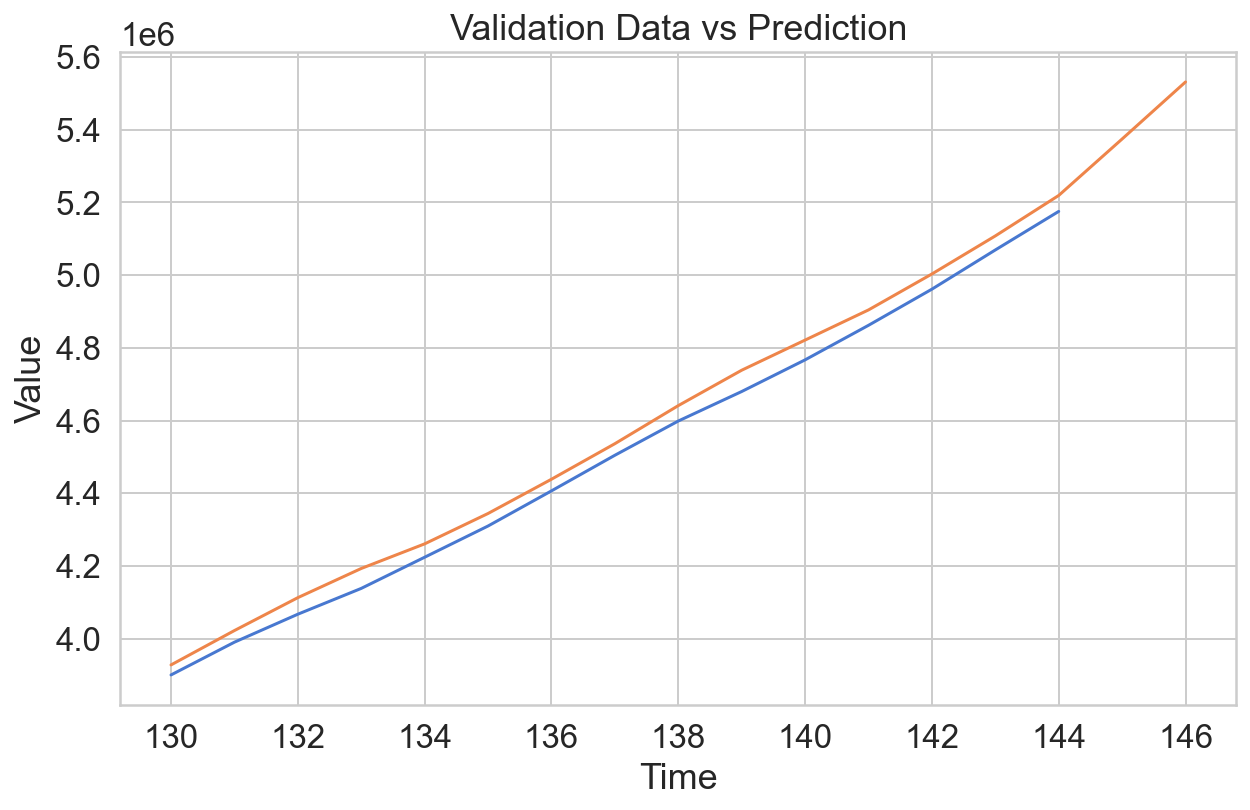

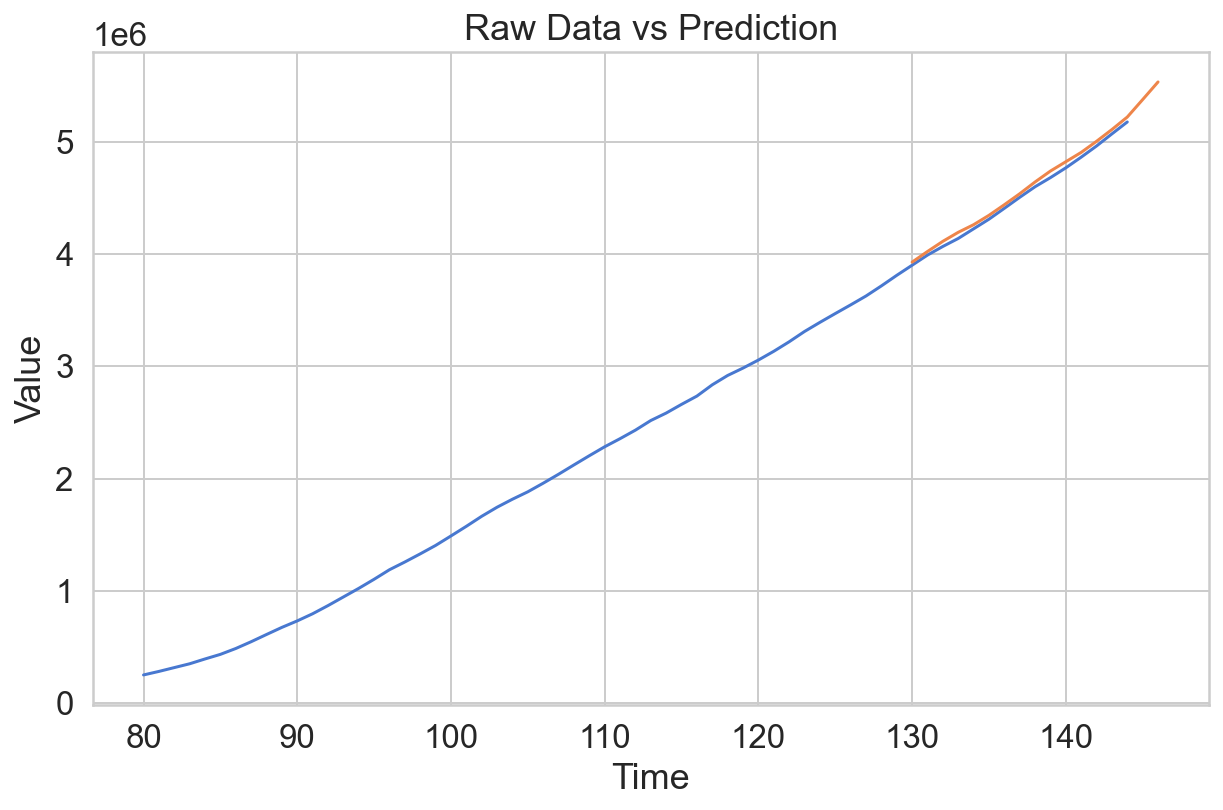

In [18]:
# ini forecast untuk yg DNN
forecast=[]
time_forecast = time_valid
step = time_forecast[-1]

# for time in range(len(series_trimmed) - window_size):
#   forecast.append(model.predict(series_trimmed[time:time + window_size][np.newaxis]))

for time in range(len(series_trimmed) - window_size):
  prediction = model.predict(series_trimmed[time:time + window_size][np.newaxis])
  # print("forecast at = ", time, " window dataset =", series_trimmed[time:time + window_size][np.newaxis], " is = ", prediction)  
  forecast.append(prediction)

for future in range (2): # predict for the next 3 days
  next_window = []
  for r in range(window_size):
    next_window.append( forecast[-window_size + r][0].item() ) # use previous prediction data to predict the future  
  step = step + 1
  time_forecast = np.append(time_forecast, [step])
  next_window = np.array(next_window)[np.newaxis]
  prediction = model.predict(next_window)
  # print("next window = ", next_window)
  # print("next time = ", step)
  # print("prediction = ", prediction)
  forecast.append(prediction)




forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plt.title("Validation Data vs Prediction")
plot_series(time_valid, x_valid)
plot_series(time_forecast, results)


plt.figure(figsize=(10, 6))
plt.title("Raw Data vs Prediction")
plot_series(time_trimmed, series_trimmed)
plot_series(time_forecast, results)



In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()